In [522]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
# import numba
from numba import njit
import plotly.graph_objects as go

In [523]:
savedir = "./"
L = 16
start = 5
ideal = 0
binsize = L//2 - 1
correlated = True

kappa = 0.0
kbt = 1e-7
u0 = 0
cs2 = 1/3
gamma = 1.0
Lambda = 0.4
T = 0.25
rho0 = 1.0

# Helper functions

In [524]:
@njit()
def cholesky_decomp(arr_in, n, bstart):
    A = arr_in.copy()
    # sum = 0
    for i in range(bstart, n):
        for j in range(bstart, i + 1):
            sum = A[i*n + j]
            for k in range(j - 1, bstart - 1, -1):
                sum -= A[i*n+k]*A[j*n+k]
            if i == j:
                if sum >= 0:
                    A[i*n+j] = np.sqrt(sum)
                else:
                    A[i*n+j] = 0
                    raise ValueError(f"Row {i} in matrix not spd!")
            else:
                if A[j*n+j] > 0:
                    A[i*n+j] = sum/A[j*n+j]
                else:
                    raise ValueError("Matrix diagonal is 0")

    for i in range(0, n):
        for j in range(i + 1, n):
            A[i*n+j] = 0

    return A

In [525]:
def covariance_matrix(k2, chi, T, kappa):
    rho0 = 1.0
    C0 = 0.5
    kT = 1e-7
    tau_r = 0.788675
    tau_p = 1.0
    Gamma = 1.0

    lambda_r = 1./tau_r
    lambda_p = 1./tau_p
    cs2 = T*rho0/(rho0-C0) - 2.*chi*(C0/rho0)**2 + kappa*k2*rho0
    # mu0 = -chi*(2.*C0 - rho0)/rho0 + T*np.log(C0/(rho0 - C0)) + C0*k2*kappa
    mu_rho = -T/(rho0-C0) + 2*chi*C0/(rho0*rho0) - kappa*k2
    mu_C = T*rho0/(C0*(rho0-C0)) - 2*chi/rho0 + 2*kappa*k2
    p_C = chi*(4*C0/rho0-1) - T*(np.log(C0)+1) + T*(np.log(rho0-C0)+C0/(rho0-C0))

    Xi = np.zeros((38, 38))

    # THESE ARE NOT DISCRETIZED IN TIME. THAT STEP IS IN THE THERMALIZE MOMENTS FUNCTION
    # diagonals
    Xi[ 5, 5] = 2.*Gamma*kT*lambda_p/rho0
    Xi[ 6, 6] = 2.*Gamma*kT*lambda_p/rho0
    Xi[ 7, 7] = 2.*Gamma*kT*lambda_p/rho0
    Xi[ 8, 8] = 2.*rho0*kT*lambda_r*(5. - 9.*cs2)
    Xi[ 9, 9] = 8.*rho0*kT*lambda_r
    Xi[10,10] = 8./3.*rho0*kT*lambda_r
    Xi[11,11] = 2./3.*rho0*kT*lambda_r
    Xi[12,12] = 2./3.*rho0*kT*lambda_r
    Xi[13,13] = 2./3.*rho0*kT*lambda_r
    Xi[14,14] = 4.*rho0*kT*lambda_r
    Xi[15,15] = 4.*rho0*kT*lambda_r
    Xi[16,16] = 4.*rho0*kT*lambda_r
    Xi[17,17] = 4./3.*rho0*kT*lambda_r
    Xi[18,18] = 4./3.*rho0*kT*lambda_r
    Xi[19,19] = 4./3.*rho0*kT*lambda_r
    Xi[20,20] = 18.*rho0*kT*lambda_r*(1. - cs2)
    Xi[21,21] = 8.*rho0*kT*lambda_r
    Xi[22,22] = 8./3.*rho0*kT*lambda_r
    Xi[23,23] = 2.*Gamma*kT*lambda_p*(-9.*Gamma*mu_C + 5.)/rho0
    Xi[24,24] = 8.*Gamma*kT*lambda_p/rho0
    Xi[25,25] = 8./3.*Gamma*kT*lambda_p/rho0
    Xi[26,26] = 2./3.*Gamma*kT*lambda_p/rho0
    Xi[27,27] = 2./3.*Gamma*kT*lambda_p/rho0
    Xi[28,28] = 2./3.*Gamma*kT*lambda_p/rho0
    Xi[29,29] = 4.*Gamma*kT*lambda_p/rho0
    Xi[30,30] = 4.*Gamma*kT*lambda_p/rho0
    Xi[31,31] = 4.*Gamma*kT*lambda_p/rho0
    Xi[32,32] = 4./3.*Gamma*kT*lambda_p/rho0
    Xi[33,33] = 4./3.*Gamma*kT*lambda_p/rho0
    Xi[34,34] = 4./3.*Gamma*kT*lambda_p/rho0
    Xi[35,35] = 18.*Gamma*kT*lambda_p*(-Gamma*mu_C + 1)/rho0
    Xi[36,36] = 8.*Gamma*kT*lambda_p/rho0
    Xi[37,37] = 8.*Gamma*kT*lambda_p/rho0

    # rho-rho sector
    Xi[ 1, 8] = -3.*kT*lambda_r*(C0*k2*kappa + p_C)/(rho0*mu_C)
    Xi[ 8, 1] = Xi[ 1, 8]
    Xi[ 5, 2] = -C0*kT*lambda_p
    Xi[ 6, 3] = Xi[ 5, 2]
    Xi[ 7, 4] = Xi[ 5, 2]
    Xi[ 2, 5] = Xi[ 5, 2]
    Xi[ 3, 6] = Xi[ 5, 2]
    Xi[ 4, 7] = Xi[ 5, 2]

    # phi-phi sector
    Xi[20,23] = 3.*kT*(Gamma*np.power(rho0, 2)*lambda_p*mu_C*mu_rho*(3.*cs2 - 1.) + lambda_r*(3.*Gamma*mu_C - 1.)*(C0*kappa*k2 + p_C)*cs2)/(rho0*mu_C*cs2)
    Xi[20,35] = -Xi[20,23]
    Xi[32,20] = Xi[20,23]
    Xi[35,20] = -Xi[20,23]
    Xi[35,23] = 6.*Gamma*kT*lambda_p*(3.*Gamma*mu_C - 1.)/rho0
    Xi[23,35] = Xi[35,23]

    # rho-phi sector
    Xi[ 1,20] = -Xi[ 1, 8]
    Xi[ 8,20] = 6.*rho0*kT*lambda_r*(3.*cs2 - 1.)
    Xi[ 8,23] = -Xi[20,23]
    Xi[ 8,35] = Xi[20,23]
    Xi[ 0,23] = -3.*Gamma*rho0*kT*lambda_p*mu_rho/cs2
    Xi[ 0,35] = -Xi[0,23]

    # phi-rho sector
    Xi[20, 1] = -Xi[ 1, 8]
    Xi[23, 0] = Xi[ 0,23]
    Xi[35, 0] = -Xi[ 0,23]
    Xi[20, 8] = Xi[ 8,23]
    Xi[23, 8] = -Xi[20,23]
    Xi[35, 8] = Xi[20,23]

    return Xi

In [526]:
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    return -out/cs2

def model_cs2(density, C0):
    # return T*density/(density - C0) - 2*Lambda*(C0/density)**2
    return T

def cs2k(kx, ky, kz, density, C0):
    thermal_cs2 = model_cs2(density, C0)
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    if correlated:
        out = thermal_cs2 + k2*kappa*rho0
    else:
        out = thermal_cs2
    return out

def mu_c(density, C0):
    return T*density/(C0*(density - C0)) - 2*Lambda/density

def mu_ck(kx, ky, kz, density, C0):
    ref_state = mu_c(density, C0)
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    if correlated:
        out = ref_state + 2*kappa*k2
    else:
        out = ref_state
    return out

In [527]:
def spherically_averaged_structure_factor(data, density, C0, scale_factor = 1, func = None, shift = True, cs = True):
    L = min(data.shape)
    S = data.copy()

    if shift:
        freqs = fft.fftshift(fft.fftfreq(L))
    else:
        freqs = fft.fftfreq(L)
    if len(data.shape) == 3:
        kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
        k = np.stack([kx, ky, kz], axis = -1)
    elif len(data.shape) == 2:
        kx, ky = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L]]), indexing='ij')
        k = np.stack([kx, ky], axis = -1)
     
    k1 = np.linalg.norm(k, axis=-1).flatten()
    
    if func is not None:
        if cs:
            S = func(S, cs2k(kx, ky, kz, density, C0))
        else:
            S = func(S, mu_ck(kx, ky, kz, density, C0))
    S /= scale_factor

    S1 = S.flatten()
    kmin = 2*np.pi/L # sampling frequency
    where = np.s_[:]#np.where(k1<=kmax)
    bins = np.arange(L//2+1)*kmin # kmax+1 for bin_edges: len(bins)=len(hist)+1
    
    shells = np.histogram(k1[where], bins, weights=S1[where])[0]
    counts = np.histogram(k1[where], bins)[0]
    return (bins[:-1]+bins[1:])/2, shells/counts

In [528]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return r, azimuth, elevation

def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def radial_equilibration(data, density, C0, radius = 1, scale_factor = 1, func = None, cs = True):
    S = data.copy()
    L = min(S.shape)
    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')

    r, t, p = cart2sph(kx, ky, kz)

    if func is not None:
        if cs:
            S = func(S, cs2k(kx, ky, kz, density, C0))
        else:
            S = func(S, mu_ck(kx, ky, kz, density, C0))
    S /= scale_factor

    idxs = np.isclose(r, radius, atol = 2*np.pi/L)
    t = t[idxs]
    p = p[idxs]
    out = S[idxs]

    return t, p, out

In [529]:
def make_bins(to_bin1, binsize, to_bin2 = None):
    bins = np.linspace(to_bin1.min(), to_bin1.max(), binsize)

    out1 = np.zeros(binsize)
    shell = np.digitize(to_bin1, bins = bins, right = True)
    np.add.at(out1, shell, to_bin1)
    unique, counts = np.unique(shell, return_counts=True)
    out1 = out1[unique]
    out1 /= counts

    if to_bin2 is None:
        return bins, out1
    else:
        out2 = np.zeros(binsize)
        np.add.at(out2, shell, to_bin2)
        unique, counts = np.unique(shell, return_counts=True)
        out2 = out2[unique]
        out2 /= counts
        return out1, out2

# Validation

## Equilibration ratios

In [530]:
idx = -1
rho_data = 1.0
C1_data = 0.5
ts = yt.load(savedir+"SF_plt_mag*")
ds = ts[idx]
ad = ds.all_data()

yt : [INFO     ] 2024-08-06 16:40:29,388 Parameters: current_time              = 2000.0
yt : [INFO     ] 2024-08-06 16:40:29,389 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-08-06 16:40:29,389 Parameters: domain_left_edge          = [-50.26548246 -50.26548246 -50.26548246]
yt : [INFO     ] 2024-08-06 16:40:29,390 Parameters: domain_right_edge         = [50.26548246 50.26548246 50.26548246]


In [531]:
ds.field_list

[('boxlib', 'struct_fact_density_density'),
 ('boxlib', 'struct_fact_density_phi'),
 ('boxlib', 'struct_fact_density_ux'),
 ('boxlib', 'struct_fact_density_uy'),
 ('boxlib', 'struct_fact_density_uz'),
 ('boxlib', 'struct_fact_phi_phi'),
 ('boxlib', 'struct_fact_phi_ux'),
 ('boxlib', 'struct_fact_phi_uy'),
 ('boxlib', 'struct_fact_phi_uz'),
 ('boxlib', 'struct_fact_ux_ux'),
 ('boxlib', 'struct_fact_ux_uy'),
 ('boxlib', 'struct_fact_ux_uz'),
 ('boxlib', 'struct_fact_uy_uy'),
 ('boxlib', 'struct_fact_uy_uz'),
 ('boxlib', 'struct_fact_uz_uz')]

### Density

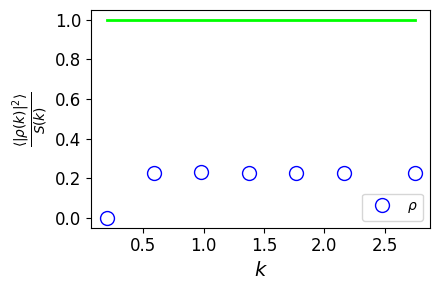

In [532]:
data = [np.array(ad[('boxlib', 'struct_fact_density_density')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\rho$"]

rho_scale = lambda a, c: a*c
scale_factor = 1
# scale_factor = cs2

for d in data:
        x, y = spherically_averaged_structure_factor(d, rho_data, C1_data, scale_factor = scale_factor, func = rho_scale)
        x, y = make_bins(x, binsize, to_bin2 = y)
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# ax.set_ylim([0.9, 1.1])
fig.tight_layout()
# fig.savefig("./equilibration_ratio.svg")

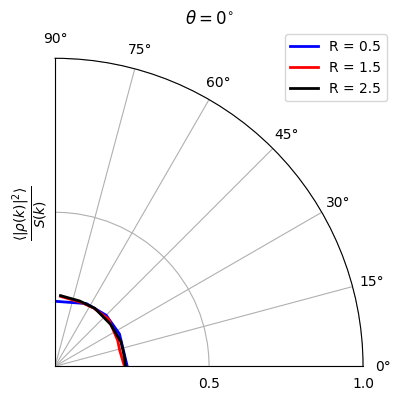

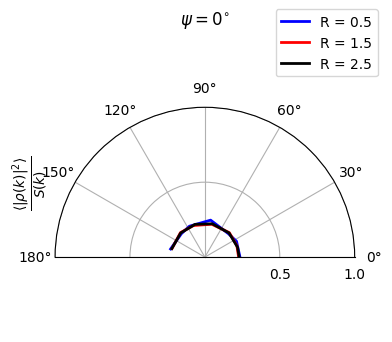

In [533]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho_data, C1_data, radius = r, func=rho_scale, scale_factor = scale_factor)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()

### C1

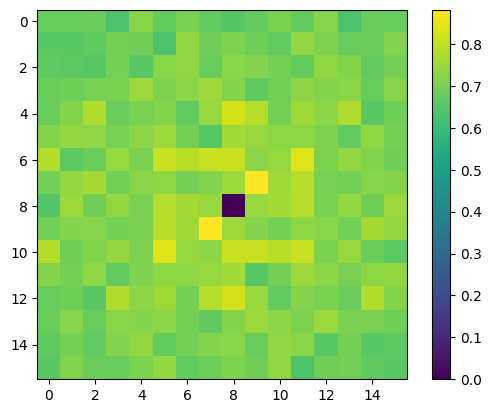

In [534]:
freqs = fft.fftshift(fft.fftfreq(L))
kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
experiment_muck = mu_ck(kx, ky, kz, 1.0, 0.5)
data = [np.array(ad[('boxlib', 'struct_fact_phi_phi')]).reshape(L, L, L)]

test = data[0]*experiment_muck

plt.imshow(test[L//2])
plt.colorbar()

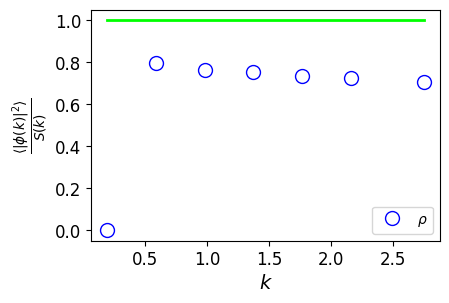

In [538]:
data = [np.array(ad[('boxlib', 'struct_fact_phi_phi')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\rho$"]

rho_scale = lambda a, c: a*c
# rho_scale = 1/cs2
scale_factor = 1

for d in data:
        x, y = spherically_averaged_structure_factor(d, rho_data, C1_data, scale_factor = scale_factor, func = rho_scale, cs = False)
        x, y = make_bins(x, binsize, to_bin2 = y)
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# ax.set_ylim([0.7, 0.8])

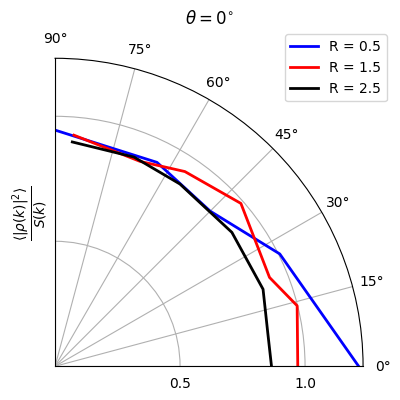

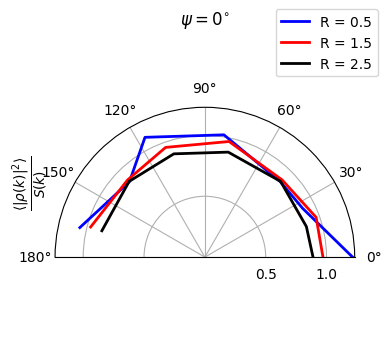

In [536]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho_data, C1_data, radius = r, func=rho_scale, scale_factor = scale_factor)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()

### Velocities

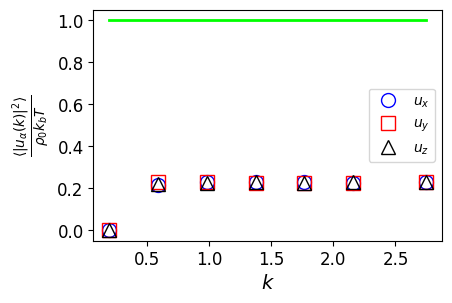

In [518]:
data = [np.array(ad[('boxlib', 'struct_fact_ux_ux')]).reshape(L, L, L), 
        np.array(ad[('boxlib', 'struct_fact_uy_uy')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_uz_uz')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$u_x$", r"$u_y$", r"$u_z$"]

for i, d in enumerate(data):
        # x, y = spherically_averaged_shells(d)
        x, y = spherically_averaged_structure_factor(d, rho_data, C1_data, scale_factor = 1)
        x, y = make_bins(x, binsize, to_bin2 = y)

        ax.plot(x, y, 
                marker = markers[i], color = colors[i],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[i])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | u_{\alpha}(k) | ^2 \rangle }{\rho_{0}k_b T}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# ax.set_ylim([0.9, 1.1])

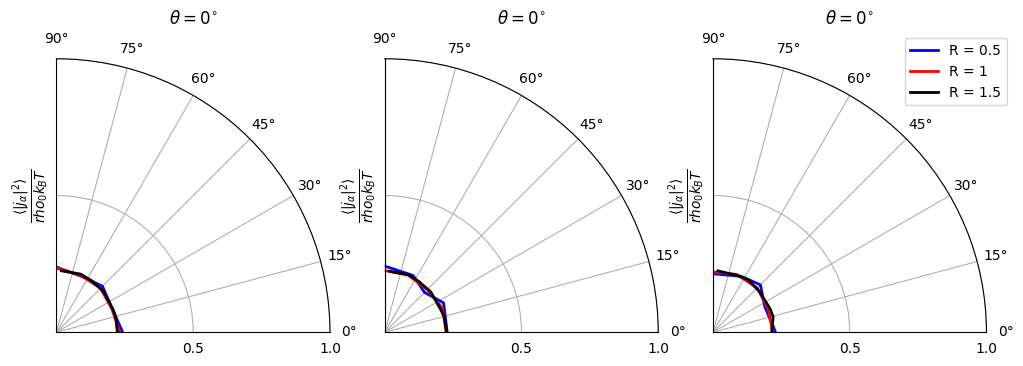

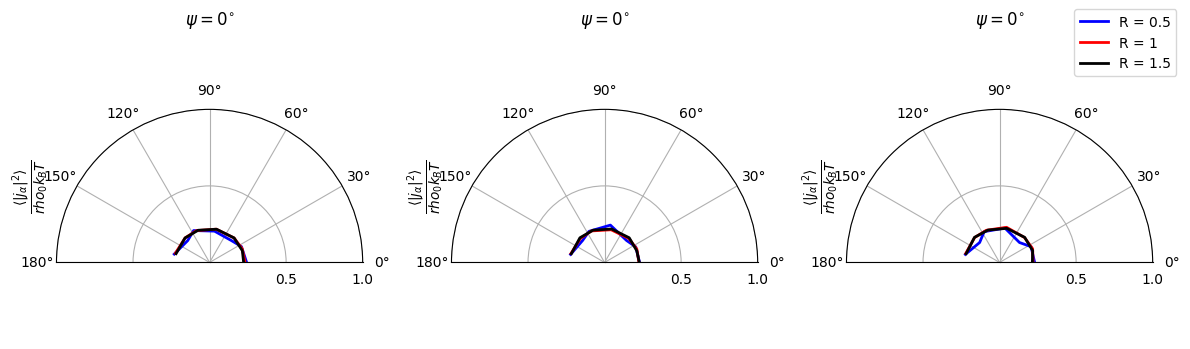

In [519]:
sz = 4
fig, tax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1, 1.5]

t_angle = 0
p_angle = 0 
# binsize = 10

for j, d in enumerate(data):
    ax1 = tax[j]
    ax2 = pax[j]
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho_data, C1_data, radius = r)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)

fig.tight_layout()

# Valid variable range

From the covariance matrix, certain limits on parameter values are set based upon ensuring that the diagonal remains positive. This limit is set by the term. $5 - c_s^2(k)$ in Xi[5, 5] which corresponds to a maximum allowable $c_s^2(k) = 0.\bar{5}$. The parameter that controls $c_s^2$ is $T$ as $c_s^2 = T$. $T_c$ or the critical temperature where demixing begins is defined as $T_c = \lambda/2$. In the expression for calculating $c_s^2(k) = c_s^2 + \kappa \rho_0 k^2$, $\kappa$ also controls the value of $c_s^2(k)$. Therefore this phase diagram will be defined using $\lambda$ and $\kappa$. Tested ranges will be $0.1 \leq \lambda \leq 1.1$ and $0.01 \leq \kappa \leq 0.05$

In [470]:
import os

if not os.path.exists("spd_covariance_matrix.npz"):
    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
    k2 = lattice_fourier_laplacian(kx, ky, kz)

    chimin = 0.2
    chimax = 0.6

    kappamin = 0.0
    kappamax = 0.05

    propmin = 1.01
    propmax = 2

    points = 10

    chi_s = np.linspace(chimin, chimax, points)
    kappa_s = np.linspace(kappamin, kappamax, points)
    prop_s = np.linspace(propmin, propmax, points)

    CHI, KAPPA, PROP = np.meshgrid(*[chi_s, kappa_s, prop_s])
    SPD = np.zeros((points, points, points))

    for x in range(points):
        for y in range(points):
            for z in range(points):
                test_spd = True
                chi = CHI[x, y, z]
                kappa = KAPPA[x, y, z]
                prop = PROP[x, y, z]
                T_in = (chi/2)*prop
                for kval in np.nditer(k2.T):
                    Xi = covariance_matrix(kval, chi, T_in, kappa)
                    try:
                        cholesky_decomp(Xi.flatten(), 38, 5)
                    except ValueError:
                        test_spd = False
                        break 
                SPD[x, y, z] = test_spd

    np.savez("spd_covariance_matrix.npz", chi = CHI, kappa = KAPPA, T = CHI/2*PROP, SPD = SPD)

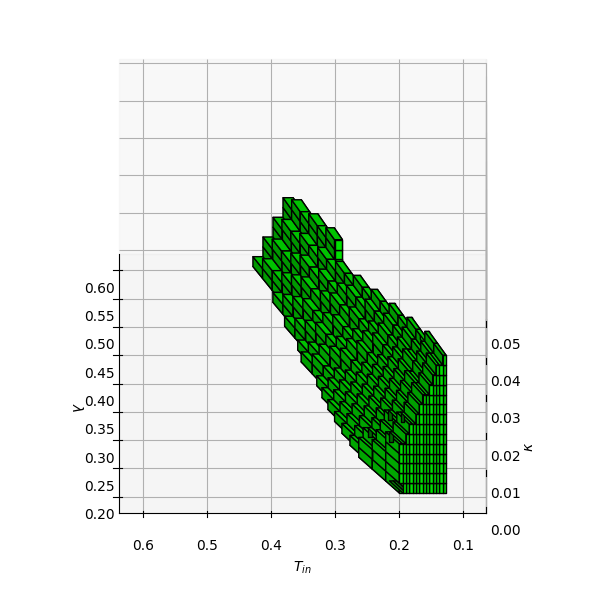

In [471]:
test = np.load("spd_covariance_matrix.npz")
CHI = test['chi']
KAPPA = test['kappa']
T = test['T']
SPD = test['SPD']

fig = plt.figure(figsize = (6, 6)) 
ax = fig.add_subplot(projection='3d')
ax.set_proj_type('ortho')
colors = np.empty(SPD.shape, dtype=object)
colors[SPD == 0] = "w"
colors[SPD == 1] = "lime"

out = ax.voxels(CHI, T, KAPPA, SPD[:-1, :-1, :-1], facecolors=colors[:-1, :-1, :-1], edgecolor='k')
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$T_{in}$")
ax.set_zlabel(r"$\kappa$")
fig.tight_layout()

ax.view_init(45, 180, 0) # ax.view_init(elev, azim, roll)
fig.tight_layout()

In [472]:
# fig, ax = plt.subplots(1, 1, figsize = (3, 3))

# slc = 5
# # im = ax.contourf(CHI[..., slc], KAPPA[..., slc], SPD[..., slc], levels = 1, colors = ['tab:gray', 'w'])
# im = ax.contourf(CHI[slc], T[slc], SPD[slc], levels = 1, colors = ['tab:gray', 'w'])
# ax.set_xlabel(r"$\lambda$")
# ax.set_ylabel(r"$\kappa$")
# ax.set_title(f"$T = {chi_s[slc]:.3f}\lambda$")

# fig.tight_layout()